In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [50]:
from google.colab import drive
drive.mount('/content/drive')
data_X=np.load('drive/My Drive/Colab Notebooks/COL870/sample_X.npy')[:512]
data_Y=np.load('drive/My Drive/Colab Notebooks/COL870/sample_Y.npy')[:512]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
class MLP_for_RRN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_for_RRN, self).__init__()
        self.fc1=nn.Linear(input_dim, output_dim)
        self.fc2=nn.Linear(output_dim, output_dim)
        self.fc3=nn.Linear(output_dim, output_dim)
        self.fc4=nn.Linear(output_dim, output_dim)
    
    def forward(self, inp):
        out = F.relu(self.fc1(inp))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [92]:
class RRN(nn.Module):
    def __init__(self, embed_dim=16, sudoku_cells=9, hidden_dim=96, num_steps=32, device='cpu'):
        # sudoku_cells means we will have sudoku_cells x sudoku_cells in the sudoku table
        super(RRN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_steps = num_steps
        self.device = device
        
        # find the required edges in the graph to have communication of message signals
        indices_of_cells=np.arange(0,sudoku_cells*sudoku_cells).reshape((sudoku_cells,sudoku_cells))
        edges_row, edges_col, edges_in_3x3=[],[],[]
        for i in range(9):
            vector = indices_of_cells[i,:]
            edges_row += [(i,j) for i in vector for j in vector if i!=j]
            vector = indices_of_cells[:,i]
            edges_col += [(i,j) for i in vector for j in vector if i!=j]
        for i in range(3):
            for j in range(3):
                vector = indices_of_cells[3*i:3*(i+1),3*j:3*(j+1)].reshape(-1)
                edges_in_3x3 += [(i,j) for i in vector for j in vector if i!=j]
        self.edges = torch.tensor(list(set(edges_row + edges_col + edges_in_3x3))).long().to(device)
        # self.edges contains all the possible pairs of communication between the cells of sudoku
        
        # create row and col labels for the cells of sudoku table
        rows, cols = [],[]
        for i in range(sudoku_cells):
            rows += [i]*sudoku_cells
            cols += [i]
        cols = cols*sudoku_cells
        self.rows, self.cols = torch.tensor(rows).long().to(device), torch.tensor(cols).long().to(device)
        
        # embedding the cell content {0,1,2,...,sudoku_cells}, row and column information for each cell in sudoku
        self.embed_dim = embed_dim
        
        # embed_1_init = torch.rand(sudoku_cells+1, self.embed_dim).to(device) #sudoku_cells+1 because possible digits in input : 0,1,2,3,...,sudoku_cells
        self.embed_1 = nn.Linear(sudoku_cells+1, self.embed_dim)#nn.Embedding.from_pretrained(embed_1_init, freeze=False) 
        
        # embed_2_init = torch.rand(sudoku_cells, self.embed_dim).to(device)
        self.embed_2 = nn.Linear(sudoku_cells, self.embed_dim)#nn.Embedding.from_pretrained(embed_2_init, freeze=False)
        
        # embed_3_init = torch.rand(sudoku_cells, self.embed_dim).to(device)
        self.embed_3 = nn.Linear(sudoku_cells, self.embed_dim)#nn.Embedding.from_pretrained(embed_3_init, freeze=False)
        
        # MLPs
        self.embeds_to_x = MLP_for_RRN(3*embed_dim, hidden_dim)
        self.message_mlp = MLP_for_RRN(2*hidden_dim, hidden_dim)
        self.r_to_o_mlp = nn.Linear(hidden_dim, sudoku_cells) # only one linear layer as given in architecture details

        # LSTM for looping over time i.e. num_steps
        self.LSTM = nn.LSTMCell(input_size=2*hidden_dim, hidden_size=hidden_dim) # since x and m will be concatentated and fed into lstm; x and m are of shape : batch_size*9*9, hidden_dim
        
        
    def forward(self, inp): # inp.shape=batch_size,9*9
        batch_size = inp.shape[0]
        inp = inp.view(-1)
        inp = F.one_hot(inp).float()
        embedded_inp = self.embed_1(inp) # batch_size*9*9, embed_dim
        
        # now also get row and column info of each cell embedded
        inp_row = self.rows.repeat(batch_size)
        inp_row = F.one_hot(inp_row).float()
        embedded_row = self.embed_2(inp_row)
        inp_col = self.cols.repeat(batch_size)
        inp_col = F.one_hot(inp_col).float()
        embedded_col = self.embed_3(inp_col)
        
        embedded_all = torch.cat((embedded_inp,embedded_row,embedded_col),dim=-1)
        x = self.embeds_to_x(embedded_all) # batch_size*9*9, hidden_dim
        
        assert x.shape[1] == self.hidden_dim

        # x will be concatenated with m and then fed into LSTM
        # find message signals : over time i.e. num_steps
        # m_{i,j}^{t} = MLP(h_{i}^{t-1}, h_{j}^{t-1} 
        # since m^t requires h^{t-1}, maintain a list of h and c
        # cell state is also required since we will use LSTM cell and loop over LSTM cell num_steps times
        
        h_0=x.clone().to(self.device)#.clone().
        h_t, c_t, o_t = [h_0],[torch.zeros(x.shape).to(device)],[]
        for t in range(self.num_steps):
            h = h_t[-1].view(batch_size,-1,self.hidden_dim)
            inp_for_msgs = h[:,self.edges].view(-1,2*self.hidden_dim)
            msgs = self.message_mlp(inp_for_msgs).view(batch_size,-1,self.hidden_dim)
            
            # now sum up the message signals appropriately
            final_msgs = torch.zeros(h.shape).to(device)
            final_msgs = final_msgs.index_add(1, self.edges[:,1], msgs) # shape : batch_size, 81, self.hidden_dim
            
            h = h.view(-1, self.hidden_dim)
            c = c_t[-1]
            final_msgs = final_msgs.view(-1, self.hidden_dim)
            
            inp_to_lstm = torch.cat((x,final_msgs),dim=-1)
            h_new, c_new = self.LSTM(inp_to_lstm, (h,c))
            
            h_t.append(h_new)
            c_t.append(c_new)
            
            o_new = self.r_to_o_mlp(h_new)
            o_t.append(o_new)
        
        out = torch.stack(o_t) # shape : num_steps, batch_size*9*9, sudoku_cells
        return out # out.shape = num_steps, batch_size*9*9, 9 : last dim is without-softmax over sudoku_cells(9)

In [93]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = RRN(embed_dim=16, sudoku_cells=9, hidden_dim=96, num_steps=32, device=device)
print(model)

optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# print(data_X[:2])
batch_size=32
dataset=TensorDataset(torch.tensor(data_X),torch.tensor(data_Y))
data_loader=DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
model = model.to(device)

RRN(
  (embed_1): Linear(in_features=10, out_features=16, bias=True)
  (embed_2): Linear(in_features=9, out_features=16, bias=True)
  (embed_3): Linear(in_features=9, out_features=16, bias=True)
  (embeds_to_x): MLP_for_RRN(
    (fc1): Linear(in_features=48, out_features=96, bias=True)
    (fc2): Linear(in_features=96, out_features=96, bias=True)
    (fc3): Linear(in_features=96, out_features=96, bias=True)
    (fc4): Linear(in_features=96, out_features=96, bias=True)
  )
  (message_mlp): MLP_for_RRN(
    (fc1): Linear(in_features=192, out_features=96, bias=True)
    (fc2): Linear(in_features=96, out_features=96, bias=True)
    (fc3): Linear(in_features=96, out_features=96, bias=True)
    (fc4): Linear(in_features=96, out_features=96, bias=True)
  )
  (r_to_o_mlp): Linear(in_features=96, out_features=9, bias=True)
  (LSTM): LSTMCell(192, 96)
)


In [98]:
num_epochs=100
train_loss,acc=[],[]
model.train()
for epoch in range(num_epochs):
    lss=0
    total,correct=0,0
    for batch_id, (X,Y) in enumerate(data_loader):
        X, Y = X.to(device).long(), Y.to(device).long()
        X = X.view(batch_size,-1)
        Y = Y.view(-1)
        Y = Y-1
        
        optimizer.zero_grad()
        
        Y_ = model(X)
        
        l=0
        for i in range(32):
            l+=loss_fn(Y_[i],Y)

        Y_pred = Y_[-1].argmax(dim=1)

        l /= batch_size

        l.backward()
        print(l.grad)
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()

        lss += l.item()
        correct += torch.all(Y_pred.view(batch_size,-1)==Y.view(batch_size,-1),dim=1).cpu().sum()
        total+=batch_size
    acc.append(correct/total)
    lss /= batch_id
    if epoch%10==0:
        print("epoch",epoch,"loss",lss,"acc",acc[-1])
    train_loss.append(lss)
    scheduler.step(lss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
epoch 0 loss 1.6374902804692586 acc tensor(0.)


Exception ignored in: <function _releaseLock at 0x7f661eb1b8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: ignored

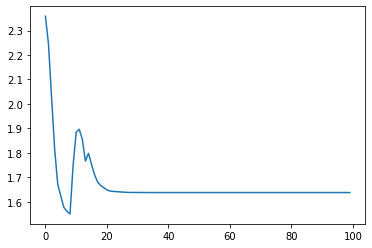

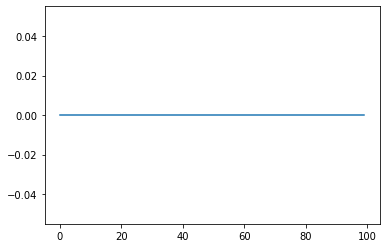

In [95]:
plt.plot(train_loss)
plt.show()
plt.plot(acc)
plt.show()

In [96]:
Y=Y.view(batch_size, -1)
Y_pred=Y_pred.view(batch_size, -1)

In [97]:
print(Y.shape)
print(Y.view(batch_size,9,9)[-1])
print(Y_pred.shape)
print(Y_pred.view(batch_size,9,9)[-1])

torch.Size([32, 81])
tensor([[6, 3, 0, 5, 1, 8, 2, 7, 4],
        [1, 2, 4, 6, 0, 7, 8, 5, 3],
        [7, 8, 5, 2, 3, 4, 0, 6, 1],
        [2, 6, 8, 7, 4, 0, 1, 3, 5],
        [0, 5, 3, 1, 6, 2, 7, 4, 8],
        [4, 1, 7, 8, 5, 3, 6, 2, 0],
        [5, 0, 6, 4, 7, 1, 3, 8, 2],
        [3, 7, 2, 0, 8, 5, 4, 1, 6],
        [8, 4, 1, 3, 2, 6, 5, 0, 7]], device='cuda:0')
torch.Size([32, 81])
tensor([[3, 6, 1, 7, 1, 7, 5, 7, 5],
        [5, 5, 5, 5, 1, 5, 5, 5, 3],
        [5, 1, 5, 2, 5, 4, 6, 6, 6],
        [5, 6, 1, 7, 5, 5, 1, 3, 5],
        [1, 5, 5, 5, 3, 6, 6, 5, 5],
        [4, 1, 7, 1, 5, 3, 6, 2, 5],
        [6, 6, 5, 5, 5, 1, 5, 1, 5],
        [6, 7, 2, 1, 7, 5, 4, 6, 3],
        [6, 4, 6, 3, 7, 3, 5, 6, 7]], device='cuda:0')


In [83]:
Y=Y.view(batch_size,-1)
Y_pred=Y_pred.view(batch_size,-1)
torch.all(Y==Y_pred, dim=1).cpu().sum()

tensor(0)

Took idea from [here](https://github.com/wDaniec/pytorch-RNN/blob/master/main.py) to implement message signals

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(input_size, HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc_out = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x
    
class Pred(nn.Module):
    def __init__(self, input_size):
        super(Pred, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EMB_SIZE = 16
HIDDEN_SIZE = 96
BATCH_SIZE = 32

In [ ]:
def get_start_embeds(embed, X):
    X = embed(X, EMB_SIZE).float()
    return X

In [ ]:
mlp1 = MLP(EMB_SIZE).to(device)
mlp2 = MLP(2*HIDDEN_SIZE).to(device)
mlp3 = MLP(2*HIDDEN_SIZE).to(device)
r = Pred(HIDDEN_SIZE).to(device)
lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE).to(device)
embed = torch.nn.functional.one_hot

optimizer_mlp1 = torch.optim.Adam(mlp1.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_mlp2 = torch.optim.Adam(mlp2.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_mlp3 = torch.optim.Adam(mlp3.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_r = torch.optim.Adam(r.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=2e-4, weight_decay=1e-4)

optimizers = [optimizer_mlp1, optimizer_mlp2, optimizer_mlp3, optimizer_r, optimizer_lstm]
criterion = nn.CrossEntropyLoss()

In [ ]:
def cross(a):
    return [(i, j) for i in a.flatten() for j in a.flatten() if not i == j]

In [ ]:
idx = np.arange(81).reshape(9, 9)
idx

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]])

In [ ]:
rows, columns, squares = [], [], []

In [ ]:
for i in range(9):
    rows += cross(idx[i, :])
    columns += cross(idx[:, i])
for i in range(3):
    for j in range(3):
        squares += cross(idx[i * 3:(i + 1) * 3, j * 3:(j + 1) * 3])

In [ ]:
edges = list(set(rows + columns + squares))
print(edges[:5])

[(40, 22), (7, 25), (1, 64), (79, 76), (44, 34)]


In [ ]:
# batched_edges = [(i + (b * 81), j + (b * 81)) for b in range(BATCH_SIZE) for i, j in edges]
# batched_edges = torch.Tensor(batched_edges).long()

In [ ]:
# print(batched_edges.shape)
# print(batched_edges.view(32,-1,2).shape)
# print(batched_edges.view(32,-1,2)[0,:5,:])

torch.Size([51840, 2])
torch.Size([32, 1620, 2])
tensor([[40, 22],
        [ 7, 25],
        [ 1, 64],
        [79, 76],
        [44, 34]])


In [ ]:
# edges = batched_edges

In [ ]:
edges = torch.tensor(edges).long()
print(edges.shape)

torch.Size([1620, 2])


In [ ]:
X,Y=next(iter(data_loader))
print(X.shape,Y.shape)
X = X.flatten()
Y = Y.flatten()
X = get_start_embeds(embed, X.long())
X = X.to(device)
Y = Y.to(device)
X = mlp1(X)
print(X.shape, X.view(32,-1,96).shape, Y.shape)

torch.Size([32, 9, 9]) torch.Size([32, 9, 9])
torch.Size([2592, 96]) torch.Size([32, 81, 96]) torch.Size([2592])


In [ ]:
for optimizer in optimizers:
    optimizer.zero_grad()

In [ ]:
H = X#.detach().clone().to(device)
loss = 0
CellState = torch.zeros(X.shape).to(device)
HiddenState = H

In [ ]:
H=H.view(batch_size,-1,96)
H.shape

torch.Size([32, 81, 96])

In [ ]:
message_inputs = H[:,edges]
print(H.shape, edges.shape, message_inputs.shape)

torch.Size([32, 81, 96]) torch.Size([1620, 2]) torch.Size([32, 1620, 2, 96])


In [ ]:
message_inputs = message_inputs.view(-1, 2*96)
messages = mlp2(message_inputs)
print(messages.shape)
messages=messages.view(batch_size,edges.shape[0],96)
print(messages.shape)

torch.Size([51840, 96])
torch.Size([32, 1620, 96])


In [ ]:
edges[:, 0].shape

torch.Size([1620])

In [ ]:
updates = torch.zeros(H.shape).to(device)
idx_j = edges[:, 1].long().to(device)
updates = updates.index_add(1, idx_j, messages)
print(updates.shape)

torch.Size([32, 81, 96])


In [ ]:
# let us dry run : whether or not index_add works as we expect
# basically : index_add does the following -- it sums up the elements getting index value x, 
# and puts it at index x in updates
random_inp = torch.rand(2,6)
random_inp

tensor([[0.2233, 0.6432, 0.3769, 0.9756, 0.9678, 0.9828],
        [0.0304, 0.5316, 0.3088, 0.7876, 0.1165, 0.8560]])

In [ ]:
oup = torch.zeros(2,4)
ind = torch.randint(4,(6,))
ind

tensor([3, 2, 2, 3, 0, 3])

In [ ]:
oup = oup.index_add(1,ind,random_inp)
oup

tensor([[0.9678, 0.0000, 1.0201, 2.1818],
        [0.1165, 0.0000, 0.8405, 1.6740]])

In [ ]:
print(0.2233+0.9756+0.9828)

2.1817


In [ ]:
print(0.0304+0.7876+0.8560)

1.674


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import sys

# sys.stdout = open('lologi.txt', 'w')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EMB_SIZE = 16
HIDDEN_SIZE = 96
BATCH_SIZE = 32

class MyDataset(Dataset):

    def __init__(self, csv_file):
        self.csv = np.array(pd.read_csv(csv_file, sep=',', header=None))
        self.csv = torch.Tensor([[[int(x) for x in my_input] for my_input in problem] for problem in self.csv]).long()
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        # res = torch.Tensor([[int(x) for x in sudoku] for sudoku in self.csv[idx]]).long()
        # return res
        return self.csv[idx][0], self.csv[idx][1]

def get_edges():
    def cross(a):
        return [(i, j) for i in a.flatten() for j in a.flatten() if not i == j]

    idx = np.arange(81).reshape(9, 9)
    rows, columns, squares = [], [], []
    for i in range(9):
        rows += cross(idx[i, :])
        columns += cross(idx[:, i])
    for i in range(3):
        for j in range(3):
            squares += cross(idx[i * 3:(i + 1) * 3, j * 3:(j + 1) * 3])
    
    edges_base = list(set(rows + columns + squares))
    batched_edges = [(i + (b * 81), j + (b * 81)) for b in range(BATCH_SIZE) for i, j in edges_base]
    return torch.Tensor(batched_edges).long()

def get_start_embeds(embed, X):
    # rows = embed(torch.Tensor([i // 9 for i in range(81)]).long(), EMB_SIZE).repeat(X.shape[0] // 81, 1) # beznadziejne rozwiazanie !!!!
    # columns = embed(torch.Tensor([i % 9 for i in range(81)]).long(), EMB_SIZE).repeat(X.shape[0] // 81, 1) # beznadziejne rozwiazanie, tez !!
    # X = torch.cat([embed(X, EMB_SIZE), rows, columns], dim=1).float()
    X = embed(X, EMB_SIZE).float()
     
    return X


def message_passing(nodes, edges, message_fn):
    n_nodes = nodes.shape[0]
    n_edges = edges.shape[0]
    n_embed = nodes.shape[1]

    message_inputs = nodes[edges]
    message_inputs = message_inputs.view(n_edges, 2*n_embed)
    messages = message_fn(message_inputs)

    updates = torch.zeros(n_nodes, n_embed).to(device)
    idx_j = edges[:, 1].to(device)
    updates = updates.index_add(0, idx_j, messages)
    return updates

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(input_size, HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc_out = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc(x))
        x = F.relu(self.fc(x))
        x = self.fc_out(x)
        return x

class Pred(nn.Module):
    def __init__(self, input_size):
        super(Pred, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
    def forward(self, x):
        x = self.fc1(x)
        return x

def one_hot(num):
    return torch.Tensor

traindataset = MyDataset('train.csv')
trainloader = DataLoader(traindataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

testdataset = MyDataset('test.csv')
testloader = DataLoader(testdataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

mlp1 = MLP(EMB_SIZE).to(device)
mlp2 = MLP(2*HIDDEN_SIZE).to(device)
mlp3 = MLP(2*HIDDEN_SIZE).to(device)
r = Pred(HIDDEN_SIZE).to(device)
lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE).to(device)
embed = torch.nn.functional.one_hot

optimizer_mlp1 = torch.optim.Adam(mlp1.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_mlp2 = torch.optim.Adam(mlp2.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_mlp3 = torch.optim.Adam(mlp3.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_r = torch.optim.Adam(r.parameters(), lr=2e-4, weight_decay=1e-4)
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=2e-4, weight_decay=1e-4)

optimizers = [optimizer_mlp1, optimizer_mlp2, optimizer_mlp3, optimizer_r, optimizer_lstm]
criterion = nn.CrossEntropyLoss()

edges = get_edges()

start_time = time.time()

def check_val():
    with torch.no_grad():
        almost_correct = 0
        correct = 0
        total = 0
        my_dict = [0 for i in range(82)]
        for batch_id, (X_batched, Y_batched) in enumerate(testloader):
            if X_batched.shape[0] != BATCH_SIZE:
                continue
            X = X_batched.flatten()

            X = get_start_embeds(embed, X)
            X = X.to(device)
            Y_batched = Y_batched.to(device)
            X = mlp1(X)
            H = X.detach().clone().to(device)

            CellState = torch.zeros(X.shape).to(device)
            HiddenState = torch.zeros(X.shape).to(device)
            for i in range(32):
                H = message_passing(H, edges, mlp2) # message_fn
                H = mlp3(torch.cat([H, X], dim=1))
                HiddenState, CellState = lstm(H, (HiddenState, CellState))
                H = CellState
                pred = r(H)


            pred = torch.argmax(pred, dim=1)

            pred = pred.view(-1, 81)
            amam = torch.sum(pred == Y_batched, dim=1)
            for x in amam:
                my_dict[x.item()] += 1

            # if batch_id % 100 == 0:
            #     print("validation: ", batch_id, '/', len(testloader))

            # print(torch.sum(X != 0, dim=1))
            correct += torch.sum(torch.sum(pred == Y_batched, dim=1) == 81)
            almost_correct += torch.sum(torch.sum(pred == Y_batched, dim=1) >= 60)
            total += Y_batched.shape[0]
        
        for i, x in enumerate(my_dict):
            print(i, ": ", x)
        
        print("Correctly solved: {}, out of: {}".format(correct, total))
        print("Almost correctly solved: {}, out of: {}".format(almost_correct, total))


for epoch in range(1000):
    running_loss = 0
    print("Started epoch: ", epoch)
    for batch_id, (X, Y) in enumerate(trainloader):
        if X.shape[0] != BATCH_SIZE:
            continue
        X = X.flatten()
        Y = Y.flatten()

        X = get_start_embeds(embed, X)

        X = X.to(device)
        Y = Y.to(device)

        X = mlp1(X)
        H = X.detach().clone().to(device)


        for optimizer in optimizers:
            optimizer.zero_grad()
        
        loss = 0
        CellState = torch.zeros(X.shape).to(device)
        HiddenState = torch.zeros(X.shape).to(device)
        for i in range(32):
            H = message_passing(H, edges, mlp2) # message_fn
            H = mlp3(torch.cat([H, X], dim=1))
            HiddenState, CellState = lstm(H, (HiddenState, CellState))
            H = CellState
            pred = r(H)
            
            loss += criterion(pred, Y)
        
        loss /= BATCH_SIZE
        running_loss += loss
        const = 200
        if(batch_id % const == 0):
            print("trainset: {} / {}".format(batch_id, len(trainloader)), end= " | ")
            print("{:.6f} updates/s".format( const / (time.time() - start_time)), end=" | ")
            print("train_loss: {:.6f}".format(running_loss.item() / const))
            running_loss = 0
            sys.stdout.flush()
            start_time = time.time()
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
    check_val()

